In [ ]:
import copy
import csv
import os
import time

import numpy as np
import torch
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score

In [ ]:
#@title
!git clone https://github.com/hanyoseob/youtube-cnn-002-pytorch-unet.git # 참고용

Cloning into 'youtube-cnn-002-pytorch-unet'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 65 (delta 29), reused 52 (delta 16), pack-reused 0
Unpacking objects: 100% (65/65), done.


# Data Load & split

In [ ]:
!gdown 1oT2UYNtv5G-lCmYxwWP0FPAmrbN9UWO6

Downloading...
From: https://drive.google.com/uc?id=1oT2UYNtv5G-lCmYxwWP0FPAmrbN9UWO6
To: /content/512_PNG_Binary-NewName_220730.zip
100% 275M/275M [00:01<00:00, 163MB/s]


In [ ]:
!unzip /content/512_PNG_Binary-NewName_220730.zip

In [ ]:
!pip install split-folders # 폴더를 train_test 나누기위한 라이브러리 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [ ]:
img = os.listdir('/content/make_data_new_name/4/images')
len(img)

115

In [ ]:
!mkdir ./split_image
!mkdir ./dataset

In [ ]:
import splitfolders

splitfolders.ratio('/content/make_data_new_name/4', output='/content/split_image',seed=115,ratio=(.7,.2,.1)) 

Copying files: 230 files [00:00, 3516.10 files/s]


우리 차량 이미지에 대입하면

input = image

label = mask


# Data Pre-Processing

TIF 또는 TIFF 파일 확장명 을 가진 파일 은 고품질 래스터 유형 그래픽을 저장하는 데 사용되는 태그있는 이미지 파일입니다.

 이 형식은 무손실 압축을 지원하므로 그래픽 아티스트와
 
  사진 작가는 품질을 손상시키지 않고 디스크 공간을 절약하기 위해 사진을 보관할 수 있습니다.

경로에서 불러서 이미지를 어레이로 바꾸고 넘파이 상태로 저장

## 복잡하니 함수화 해볼 것

In [ ]:
data_img = '/content/split_image'

train_path = os.path.join(data_img, 'train') # 각 폴더 경로 저장
val_path = os.path.join(data_img, 'val')
test_path = os.path.join(data_img, 'test')

train_list = os.listdir(train_path + '/images')
val_list = os.listdir(val_path + '/images')
test_list = os.listdir(test_path + '/images')

train_list_1 = [x[5:-4] for x in train_list]
val_list_1 = [x[5:-4] for x in val_list]
test_list_1 = [x[5:-4] for x in test_list]

img_path_1 = train_path + '/images/' # 가져오는 데이터를 분리 하기 위해 경로를 각자 설정
mask_path_1 = train_path + '/masks/'

img_path_2 = val_path + '/images/' # 가져오는 데이터를 분리 하기 위해 경로를 각자 설정
mask_path_2 = val_path + '/masks/'

img_path_3 = test_path + '/images/' # 가져오는 데이터를 분리 하기 위해 경로를 각자 설정
mask_path_3 = test_path + '/masks/'

In [ ]:
dir_save_train = os.path.join('./dataset', 'train') # 각 폴더 경로 저장
dir_save_val = os.path.join('./dataset', 'val')
dir_save_test = os.path.join('./dataset', 'test')

if not os.path.exists(dir_save_train): # 데이터 저장경로에 폴더가 없으면 생성
    os.makedirs(dir_save_train)

if not os.path.exists(dir_save_val):
    os.makedirs(dir_save_val)

if not os.path.exists(dir_save_test):
    os.makedirs(dir_save_test)

training set 저장

In [ ]:
for i in train_list_1:

    image = img_path_1 + 'image' + i + '.png'
    mask = mask_path_1 + 'mask' + i + '.png'

    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)

    np.save(os.path.join(dir_save_train, f'image_{i}.npy'), image)
    np.save(os.path.join(dir_save_train, f'mask_{i}.npy'), mask)

validation set 저장

In [ ]:
for i in val_list_1:

    image = img_path_2 + 'image' + i + '.png'
    mask = mask_path_2 + 'mask' + i + '.png'

    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)


    np.save(os.path.join(dir_save_val, f'image_{i}.npy'), image)
    np.save(os.path.join(dir_save_val, f'mask_{i}.npy'), mask)

test set 저장

In [ ]:
for i in test_list_1:

    image = img_path_3 + 'image' + i + '.png'
    mask = mask_path_3 + 'mask' + i + '.png'

    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)

    np.save(os.path.join(dir_save_test, f'image_{i}.npy'), image)
    np.save(os.path.join(dir_save_test, f'mask_{i}.npy'), mask)

In [ ]:
mask.shape

(512, 512)

matplotlib lib을 통한 출력

# UNet model

In [ ]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets

### 트레이닝 파라미터 설정

In [ ]:
lr = 1e-3 # learning rate
batch_size = 1
num_epoch = 30

data_dir = './dataset' # data path
ckpt_dir = './checkpoint' # 구간마다 정보를 저장할 체크포인트
log_dir = './log' # 기록들을 정리해놓을 log

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 네트워크 구축

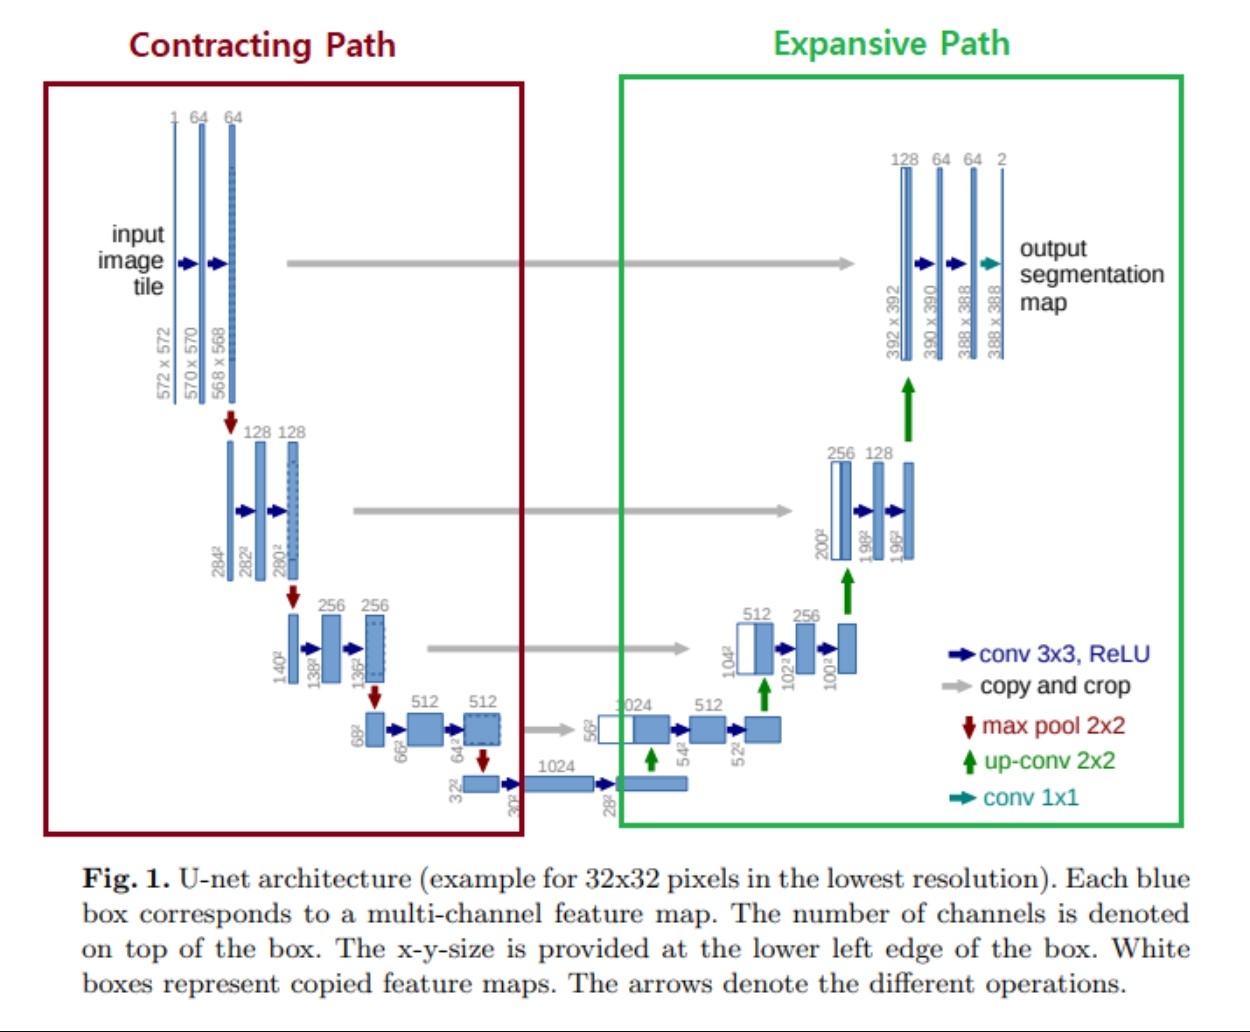

## Dropout 더 시도해 봐야함

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Enoder와 Decoder에서 반복적으로 사용되는 conv2 layer, batchnormalization, ReLU를 함수로 정의
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            # 각 레이어 (미니 배치) 마다 normalization을 하는 레이어를 둬서 변형된 분포가 나오지 않게 함
            layers += [nn.BatchNorm2d(num_features=out_channels)] 
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        # enc는 encoder, 1은 첫번째 스테이지, _1은 첫번째 스테이지의 첫번째 cbr을 의미 (파란색 화살표)

        # kernel_size, stride, padding, bias는 layer를 쌓으면서도 고정값으로 가져가기 때문에
        # CBR2d 함수에서 정의된 값들이 default, 즉 매번 작성하지 않아도 되므로 삭제
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64) 
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64) 

        # 한 스테이지가 끝날 때마다 max pooling 적용 ( 빨간색 화살표 )
        # MaxPool2d 라는 함수를 torch 내에서 가져오면 되기 때문에 전부 작성할 필요 없음 
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128) 
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128) 

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256) 
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256) 

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512) 
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512) 

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        # encoder 마지막 단으로 down convolution 파트 종료
        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.25)


        # Expansive path
        # encoder와 decoder가 페어가 되어 보일 수 있게 이름의 숫자도 대칭으로 작성
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        # 위에서의 maxpooling과는 다르게 구현되어 있는 함수가 없기 때문에 직접적으로 
        # ConvTranspose2d를 사용하여 구현해야함  ( 초록색 화살표 ) 
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        
        # decoder에서는 u_net 특성상 위 사진의 하얀색 부분인 skip connection이 이루어지기 때문에
        # in_channels에 곱하기 2가 되어 들어가야함  /   # 하얀색 화살표
        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512) 
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256) 
                            
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256) 
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128) 
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64) 
        self.dec1_1 = CBR2d(in_channels=64, out_channels=1)

        # self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    # 실행하기 위한 코드적 구현 파트

    def forward(self,x):
        # contracting path
        enc1_1 = self.enc1_1(x) # 파란 화살표
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2) # 빨간 화살표

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        # Expensive path
        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1) # 초록색 화살표
        # torch lib에서 cat (concatenate) 함수를 불러와 위에서 지정한 skip connection하여 온 페어 지정한 encoder를 합체
        cat4 = torch.cat((unpool4, enc4_2), dim=1) # dim[0=batch, 1=channel, 2=height, 3=width]
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1) 
        cat3 = torch.cat((unpool3, enc3_2), dim=1) 
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1) 
        cat2 = torch.cat((unpool2, enc2_2), dim=1) 
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1) 
        cat1 = torch.cat((unpool1, enc1_2), dim=1) 
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = dec1_1

        return x


Dropout 및 floor 추가

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# device = "cpu"
batch_size = 2
workers = 4
print("device available: ", device)     

device available:  cuda:0


In [ ]:
unet = UNet()
unet.to(device)
print(summary(unet, (1, 512, 512)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             640
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
         MaxPool2d-7         [-1, 64, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]          73,856
       BatchNorm2d-9        [-1, 128, 256, 256]             256
             ReLU-10        [-1, 128, 256, 256]               0
           Conv2d-11        [-1, 128, 256, 256]         147,584
      BatchNorm2d-12        [-1, 128, 256, 256]             256
             ReLU-13        [-1, 128, 256, 256]               0
        MaxPool2d-14        [-1, 128, 1

# Data loader

### data loader 구현

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        # 문자열 검사를 통해 'mask'이 있으면 True로 정리
        lst_mask = [f for f in lst_data if f.startswith('mask')] # 리스트들 정리
        lst_image = [f for f in lst_data if f.startswith('image')]

        lst_mask.sort() # 데이터 인덱스에 맞게 정렬
        lst_image.sort()

        self.lst_mask = lst_mask
        self.lst_image = lst_image

    def __len__(self):
        return len(self.lst_mask)      # 함수의 length를 확인하는 함수

    def __getitem__(self, index):       # 인덱스에 해당하는 파일을 로드
        mask = np.load(os.path.join(self.data_dir, self.lst_mask[index]))
        image = np.load(os.path.join(self.data_dir, self.lst_image[index]))

        mask = mask/255.0     # 0에서 1사이로 normalize 해주기 위해 255로 나눔
        image = image/255.0
        mask = mask.astype(np.float32) # 데이터셋이 다를 경우가 있을 수 있으니 형태를 플롯형으로 변환
        image = image.astype(np.float32)

        if mask.ndim == 2:     # 라벨의 차원이 2일 경우 라벨의 마지막에 차원을 임의로 추가
            mask = mask[:,:,np.newaxis]
        if image.ndim == 2:  
            image = image[:,:,np.newaxis] 

        data = {'image':image, 'mask':mask} # 생성된 라벨과 인풋을 딕셔너리 형태로 내보냄

        if self.transform:				
            data = self.transform(data)

        return data


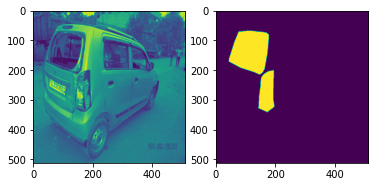

In [ ]:
dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'))

data = dataset_train.__getitem__(0)

image = data['image'] # 딕셔너리 형태에서 밸류값을 가져오고
mask = data['mask']

plt.subplot(121)
plt.imshow(image.squeeze()) # 위에서 임의로 생성한 차원의 이미지를 넣으면 에러가 생기므로
                            # squeeze 함수를 사용해 1인 차원을 가진 axis를 제거

plt.subplot(122)
plt.imshow(mask.squeeze())

plt.show()

### Transform

In [ ]:
class ToTensor(object):
    def __call__(self, data):
        mask, image = data['mask'], data['image']
		
        # numpy와 tensor의 배열 차원 순서가 다르다. 
        # numpy : (행, 열, 채널)
        # tensor : (채널, 행, 열)
        # 따라서 위 순서에 맞춰 transpose
        
        mask = mask.transpose((2, 0, 1)).astype(np.float32) 
        image = image.transpose((2, 0, 1)).astype(np.float32)
		
        # 이후 np를 tensor로 바꾸는 코드는 다음과 같이 간단하다.
        data = {'mask': torch.from_numpy(mask), 'image': torch.from_numpy(image)}

        return data
        
class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        mask, image = data['mask'], data['image']

        image = (image - self.mean) / self.std

        data = {'mask': mask, 'image': image}

        return data

class RandomFlip(object):
    def __call__(self, data):
        mask, image = data['mask'], data['image']

        if np.random.rand() > 0.5:
            mask = np.fliplr(mask)
            image = np.fliplr(image)

        if np.random.rand() > 0.5:
            mask = np.flipud(mask)
            image = np.flipud(image)

        data = {'mask': mask, 'image': image}

        return data

# Transform

In [ ]:
def dice_coef(y_pred, y_true):
    smooth = 1e-3
    numerator =   (2 * ( y_pred * y_true ).sum() + smooth)
    denominator = ( y_pred.sum() + y_true.sum()  + smooth)
    return numerator / denominator

def dice_loss(y_pred, y_true):
    return 1. - dice_coef(y_pred, y_true)

class dice(nn.Module):
    def __init__(self):
        super(dice, self).__init__()
        
    def forward(self, y_pred, y_true):
        return dice_loss(y_pred, y_true)

def dsc(y_pred, y_true):
    smooth = 1e-3
    y_pred, y_true = torch.round(y_pred), torch.round(y_true)
    numerator = (2 * ( y_pred * y_true ).sum() + smooth)
    denominator = ( y_pred.sum() + y_true.sum()  + smooth)
    return numerator / denominator

class bce_dice_loss(nn.Module):
    def __init__(self):
        super(bce_dice_loss, self).__init__()
        self.loss = nn.BCELoss()
        # self.loss = nn.BCEWithLogitsLoss(weight=None, size_average=None, reduce=None, reduction='mean', pos_weight=None)

        
    def forward(self, mask_pred, mask_true):
        return dice_loss(mask_pred, mask_true)

# numpy를 이용한 iou 계산 함수
def prod_iou(pred, true):
    pred = pred.int()
    true = true.int()

    intersection = (pred & true).float().sum((1, 2))
    union = (pred | true).float().sum((1, 2))

    iou = (intersection + EPS) / (union + EPS)

    return iou.mean()


# 위에서 지정한 함수 compose
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])

# 경로에서 가져온 데이터 transform 적용
dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)

# 데이터로더를 거쳐서 위에 적용된 부분을 가져옴
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

# val
dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)

metrics = {'f1_score': f1_score, 'auroc': roc_auc_score, 'iou': iou_np}

# 네트워크 생성
net = UNet().to(device) # 네트워크 

# criterion = nn.BCEWithLogitsLoss().to(device) # BCEloss 와 logitloss가 합쳐진 형태 
# (logitloss는 sigmoid를 포함하고 있어 따로 추가해주지 않아도됨)
# 현재 우리의 방향은 iou점수를 내기 위해 모델에서 학습을 끝내고 온 output을 fc에 넣지 않고
# trainer에 넣고 돌릴 input으로 반환하기 위해 sigmoid를 거치면 안되었음
# 그래서 단독으로 있는 BCE_dice_loss만 사용해서 out을 뽑고 점수를 기록하려함

criterion = bce_dice_loss().to(device) # 손실 
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # optimizer

# Variables 설정
# 로스를 계산하기 위해 필요함
num_data_train = len(dataset_train) # 데이터의 개수를 설정
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size) # 배치사이즈에 의해서 나누어지는 트레이닝 셋의 수 계산
num_batch_val = np.ceil(num_data_val / batch_size)

# Functions 설정
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1) # from tensor to numpy
fn_denorm = lambda x, mean, std: (x * std) + mean # normaliztion 되어있는 데이터를 반대로 denormalization 해줌
fn_class = lambda x: 1.0 * (x > 0.5) # 아웃풋의 이미지를 바이너리 클래스로 분류해주는 function 정의

# Tensorboard SummaryWriter 설정
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train')) # 기록들을 tensorboard를 통한 그래프를 작성
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))      # 해주기 위한 function 설정

# 네트워크 저장하기
# train을 마친 네트워크 저장 
# net : 네트워크 파라미터, optimizer  두개를 dict 형태로 저장
def save(ckpt_dir,net,optimizer,epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net':net.state_dict(),'optimizer':optimizer.state_dict()},'%s/model_epoch%d.pt'%(ckpt_dir,epoch))

# 네트워크 불러오기
def load(ckpt_dir,net,optimizer):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        epoch = 0
        return net, optimizer, epoch
    
    ckpt_lst = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir,ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optimizer.load_state_dict(dict_model['optimizer'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pt')[0])

    return net,optimizer,epoch



# Train

In [ ]:
batch_size = 1
num_epoch = 5

## UNet 직접 구현 코드

In [ ]:
#@title
st_epoch = 0 # 트레이닝이 시작되는 에폭의 포지션을 0으로 설정

for epoch in range(st_epoch + 1, num_epoch + 1):
    net.train() # 네트워크에게 트레인이라는 모드를 알려주는 function 설정
    loss_arr = []
    # forward pass              /       네트워크의 인풋을 받아 아웃풋을 출력
    for batch, data in enumerate(loader_train, 1):
        mask = data['mask'].to(device)
        image = data['image'].to(device)

        output = net(image)
        # backward pass         /       back propagation
        optimizer.zero_grad()

        loss = criterion(output, mask)
        loss.backward()

        optimizer.step()

        # 손실함수 계산
        loss_arr += [loss.item()]

        print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
            (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))
        

        # Tensorboard 저장
        mask = fn_tonumpy(mask)
        image = fn_tonumpy(fn_denorm(image, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_class(output))

        writer_train.add_image('mask', mask, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('image', image, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

    writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

    # validation
    with torch.no_grad(): # validation 이기 때문에 backpropa 진행 x, 학습된 네트워크가 정답과 얼마나 가까운지 loss만 계산
        net.eval() # 네트워크를 evaluation 용으로 선언
        loss_arr = []

        for batch, data in enumerate(loader_val,1):
            # forward
            mask = data['mask'].to(device)
            image = data['image'].to(device)
            output = net(image)

            # loss 
            loss = criterion(output,mask)
            loss_arr += [loss.item()]
            print('valid : epoch %04d / %04d | Batch %04d \ %04d | Loss %04d'%(epoch,num_epoch,batch,num_batch_val,np.mean(loss_arr)))

            # Tensorboard 저장하기
            mask = fn_tonumpy(mask)
            image = fn_tonumpy(fn_denorm(image, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))

            writer_val.add_image('mask', mask, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('image', image, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

        # epoch이 끝날때 마다 네트워크 저장
        if epoch % 5 ==0:
            save(ckpt_dir=ckpt_dir, net = net, optimizer = optimizer, epoch = epoch)

writer_train.close()
writer_val.close()




## UNet에 맞게 custom한 trainer

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

model=net
bpath=log_dir
num_epochs=num_epoch

since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 1e10
# Use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
# Initialize the log file for training and Valing loss and metrics
fieldnames = ['epoch', 'Train_loss', 'Val_loss'] + \
    [f'Train_{m}' for m in metrics.keys()] + \
    [f'Val_{m}' for m in metrics.keys()]
with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

for epoch in range(1, num_epochs + 1):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print('-' * 40)
    # Each epoch has a training and validation phase
    # Initialize batch summary
    batchsummary = {a: [0] for a in fieldnames}

    # mask = fn_tonumpy(mask)
    # image = fn_tonumpy(fn_denorm(image, mean=0.5, std=0.5))            내일 확인해보기
    # output = fn_tonumpy(fn_class(output))

    for phase in ['Train', 'Val']:
        if phase == 'Train':
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        ious = 0
        cnt = 0
        # iou_Val = 0

        # Iterate over data.
        for batch, data in tqdm(enumerate(loader_train, 1)):
            cnt += 1
            mask = data['mask'].to(device)
            image = data['image'].to(device)

            
            # zero the parameter gradients
            optimizer.zero_grad()

            # track history if only in train
            with torch.set_grad_enabled(phase == 'Train'):
                output = model(image)
                loss = criterion(output, mask)

                y_pred = output.data.cpu().numpy().ravel()
                y_true = mask.data.cpu().numpy().ravel()
                
                batch_size = mask.shape[0]
                ious += iou_np(y_pred, y_true)

                for name, metric in metrics.items():
                    if name == 'f1_score':

                        batchsummary[f'{phase}_{name}'].append(
                            metric(y_true > 0, y_pred > 0.1))
                    elif name == 'auroc':
                        batchsummary[f'{phase}_{name}'].append(
                            metric(y_true.astype('uint8'), y_pred))

                if phase == 'Train':
                    loss.backward()
                    optimizer.step()
        # print('i/c : {}\n\n'.format(ious / cnt))
        batchsummary[f'{phase}_iou'] = ious / cnt

        batchsummary['epoch'] = epoch
        epoch_loss = loss
        batchsummary[f'{phase}_loss'] = epoch_loss.item()
        print('{} Loss: {:.4f}'.format(phase, loss))

    for field in fieldnames[3:]:
        batchsummary[field] = np.mean(batchsummary[field])
    print(batchsummary)
    with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow(batchsummary)
        # deep copy the model
        if phase == 'Val' and loss < best_loss:
            best_loss = loss
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Lowest Loss: {:4f}'.format(best_loss))

# epoch이 끝날때 마다 네트워크 저장
if batchsummary['epoch'] % 5 ==0:
    save(ckpt_dir=ckpt_dir, net = net, optimizer = optimizer, epoch = batchsummary['epoch'])

# load best model weights
model.load_state_dict(best_model_wts)


Epoch 1/5
----------------------------------------


40it [00:25,  1.55it/s]

Train Loss: 0.8438



40it [00:15,  2.56it/s]

Val Loss: 0.9853
{'epoch': 1, 'Train_loss': 0.843777060508728, 'Val_loss': 0.9852839112281799, 'Train_f1_score': 0.12090154590217231, 'Train_auroc': 0.621296711783456, 'Train_iou': 0.08728249674640598, 'Val_f1_score': 0.04920220373671673, 'Val_auroc': 0.5076201443985794, 'Val_iou': 0.030081962767609615}
Epoch 2/5
----------------------------------------



40it [00:25,  1.57it/s]

Train Loss: 0.9318



40it [00:15,  2.53it/s]

Val Loss: 0.9662
{'epoch': 2, 'Train_loss': 0.9318215250968933, 'Val_loss': 0.9662066102027893, 'Train_f1_score': 0.13310819479485356, 'Train_auroc': 0.6352833393186272, 'Train_iou': 0.09015644013180175, 'Val_f1_score': 0.1115073837086413, 'Val_auroc': 0.626172451145156, 'Val_iou': 0.12856583636010194}
Epoch 3/5
----------------------------------------



40it [00:25,  1.59it/s]

Train Loss: 0.9160



40it [00:15,  2.58it/s]

Val Loss: 0.9760
{'epoch': 3, 'Train_loss': 0.9159874320030212, 'Val_loss': 0.9760012626647949, 'Train_f1_score': 0.145863420696347, 'Train_auroc': 0.6054434039329302, 'Train_iou': 0.15081281453357115, 'Val_f1_score': 0.0669105968315854, 'Val_auroc': 0.4768603180807457, 'Val_iou': 0.04896155330398015}
Epoch 4/5
----------------------------------------



40it [00:25,  1.58it/s]

Train Loss: 0.4993



40it [00:15,  2.53it/s]

Val Loss: 0.9686
{'epoch': 4, 'Train_loss': 0.49925899505615234, 'Val_loss': 0.9685632586479187, 'Train_f1_score': 0.07049898434350024, 'Train_auroc': 0.4893416976182398, 'Train_iou': 0.04486214556749845, 'Val_f1_score': 0.11912943018692623, 'Val_auroc': 0.565943209334421, 'Val_iou': 0.0735826594623109}
Epoch 5/5
----------------------------------------



40it [00:25,  1.60it/s]

Train Loss: 0.8995



40it [00:15,  2.54it/s]


Val Loss: 0.8631
{'epoch': 5, 'Train_loss': 0.8994597792625427, 'Val_loss': 0.8631025552749634, 'Train_f1_score': 0.14491188264912191, 'Train_auroc': 0.6037506838331966, 'Train_iou': 0.1508148497364889, 'Val_f1_score': 0.0687186691695932, 'Val_auroc': 0.4932420897246215, 'Val_iou': 0.03332788176915231}
Training complete in 3m 30s
Lowest Loss: 0.863103


<All keys matched successfully>

# Test

In [ ]:
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

dataset_test = Dataset(data_dir=os.path.join(data_dir, 'test'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=8)

# 그밖에 부수적인 variables 설정하기
num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / batch_size)

# 결과 디렉토리 생성하기
result_dir = os.path.join('./', 'result')
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))


net, optimizer, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optimizer=optimizer)

with torch.no_grad():
      net.eval()
      loss_arr = []

      for batch, data in tqdm(enumerate(loader_test, 1)):
          # forward pass
          mask = data['mask'].to(device)
          image = data['image'].to(device)

          output = net(image)

          # 손실함수 계산하기
          loss = criterion(output, mask)

          loss_arr += [loss.item()]

          print("TEST: BATCH %04d / %04d | LOSS %.4f" %
                (batch, num_batch_test, np.mean(loss_arr)))

          # Tensorboard 저장하기
          mask = fn_tonumpy(mask)
          image = fn_tonumpy(fn_denorm(image, mean=0.5, std=0.5))
          output = fn_tonumpy(fn_class(output))

          # 테스트 결과 저장하기
          for j in range(mask.shape[0]):
              id = num_batch_test * (batch - 1) + j

              plt.imsave(os.path.join(result_dir, 'png', 'mask_%04d.png' % id), mask[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'image_%04d.png' % id), image[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')

              np.save(os.path.join(result_dir, 'numpy', 'mask_%04d.npy' % id), mask[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'image_%04d.npy' % id), image[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())

print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
        (batch, num_batch_test, np.mean(loss_arr)))

In [ ]:
##
lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

lst_mask = [f for f in lst_data if f.startswith('mask')]
lst_image = [f for f in lst_data if f.startswith('image')]
lst_output = [f for f in lst_data if f.startswith('output')]

lst_mask.sort()
lst_image.sort()
lst_output.sort()

##
id = 0

mask = np.load(os.path.join(result_dir,"numpy", lst_mask[id]))
image = np.load(os.path.join(result_dir,"numpy", lst_image[id]))
output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

## 플롯 그리기
plt.figure(figsize=(8,6))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('image')

plt.subplot(132)
plt.imshow(mask, cmap='gray')
plt.title('mask')

plt.subplot(133)
plt.imshow(output*200, cmap='gray')
plt.title('output')

plt.show()